---
title: Lieb Model QPC
date: 2022-06-01
date-format: short
---

In [1]:
import kwant
import matplotlib
import matplotlib.pyplot as plt

import scipy as scp
import numpy as np
from kwant.physics import dispersion
from scipy import sparse as sp

In the `make_system` function, the lattice is defined using `kwant.lattice.Polyatomic`. The lattice vectors and basis vectors are specified, and sublattices `lat.a`, `lat.b`, and `lat.c` are assigned accordingly.

A Builder object called `syst` is created to define the system.

The code then sets the potential on different sublattices using the potential function.

The hopping elements in the Hamiltonian are defined next. Multiple lines of code set the hopping terms between different combinations of lattice sites, utilizing the syst object and the provided range of lattice indices.


In [2]:
def make_system(a=1, t_1=1.0, t_2=1.0, L=3, W=3, potential=lambda x: 0, lead=True):
    lat = kwant.lattice.Polyatomic(
        [[2 * a, 0], [0, 2 * a]], [[0, 0], [0, a], [a, 0]], norbs=1
    )
    lat.a, lat.b, lat.c = lat.sublattices

    syst = kwant.Builder()

    # Potential
    syst[(lat.a(n, m) for n in range(L) for m in range(W + 1))] = potential
    syst[(lat.b(n, m) for n in range(L) for m in range(W))] = potential
    syst[(lat.c(n, m) for n in range(L) for m in range(W + 1))] = potential

    # Hopping t1
    syst[((lat.a(n, m), lat.b(n, m)) for n in range(L) for m in range(W))] = t_1
    syst[((lat.a(n, m), lat.c(n, m)) for n in range(L) for m in range(W + 1))] = t_1
    syst[((lat.b(n, m), lat.c(n, m)) for n in range(L) for m in range(W))] = t_2
    syst[((lat.b(n + 1, m), lat.c(n, m)) for n in range(L - 1) for m in range(W))] = t_2
    syst[
        ((lat.b(n, m - 1), lat.c(n, m)) for n in range(L) for m in range(1, W + 1))
    ] = t_2
    syst[
        ((lat.b(n - 1, m + 1), lat.c(n, m)) for n in range(1, L) for m in range(W - 1))
    ] = t_2  #
    syst[
        ((lat.b(n, m), lat.a(n, m + 1)) for n in range(L) for m in range(W - 1 + 1))
    ] = t_1
    syst[
        ((lat.c(n, m), lat.a(n + 1, m)) for n in range(L - 1) for m in range(W + 1))
    ] = t_1
    syst[((lat.c(n, W), lat.b(n + 1, W - 1)) for n in range(L - 1))] = t_2

    # Hopping t2
    if not lead:
        return syst, lat

    # Left lead
    sym_left_lead = kwant.TranslationalSymmetry([-2 * a, 0])
    left_lead = kwant.Builder(sym_left_lead)
    # Onsites
    left_lead[(lat.a(n, m) for n in range(L) for m in range(W + 1))] = 0
    left_lead[(lat.b(n, m) for n in range(L) for m in range(W))] = 0
    left_lead[(lat.c(n, m) for n in range(L) for m in range(W + 1))] = 0
    # Hopping t1
    left_lead[((lat.a(n, m), lat.b(n, m)) for n in range(L) for m in range(W))] = t_1
    left_lead[
        ((lat.a(n, m), lat.c(n, m)) for n in range(L) for m in range(W + 1))
    ] = t_1
    left_lead[((lat.b(n, m), lat.c(n, m)) for n in range(L) for m in range(W))] = t_2
    left_lead[
        ((lat.b(n + 1, m), lat.c(n, m)) for n in range(L - 1) for m in range(W))
    ] = t_2
    left_lead[
        ((lat.b(n, m - 1), lat.c(n, m)) for n in range(L) for m in range(1, W + 1))
    ] = t_2
    left_lead[
        ((lat.b(n - 1, m + 1), lat.c(n, m)) for n in range(1, L) for m in range(W - 1))
    ] = t_2
    left_lead[
        ((lat.b(n, m), lat.a(n, m + 1)) for n in range(L) for m in range(W - 1 + 1))
    ] = t_1
    left_lead[
        ((lat.c(n, m), lat.a(n + 1, m)) for n in range(L - 1) for m in range(W + 1))
    ] = t_1

    left_lead[((lat.c(n, W), lat.b(n + 1, W - 1)) for n in range(L - 1))] = t_2

    syst.attach_lead(left_lead)
    left_lead_fin = left_lead.finalized()
    syst.attach_lead(left_lead.reversed())

    syst_fin = syst.finalized()

    return syst_fin, syst, left_lead_fin, lat


These functions provide useful tools for visualizing and analyzing some of the properties of our system

In [ ]:
def plot_bandstructure(flead, momenta, label=None, title=None):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]

    plt.figure()
    plt.title(title)
    plt.plot(momenta, energies, label=label)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    plt.show()


def plot_conductance(syst, energies):
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(1, 0))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.show()


def plot_density(sys, ener, it=-1, title="empty", ax=None):
    wf = kwant.wave_function(sys, energy=ener)
    t = np.shape(wf(0))
    nwf = wf(0)[0] * 0

    for i in range(t[0] // 2 + 1):
        test = wf(0)[i]
        nwf += test

    psi = abs(nwf) ** 2

    kwant.plotter.map(sys, psi, method="linear", vmin=0, ax=ax)


def plot_current(sys, ener, it=-1, title="empty", ax=None):
    wf = kwant.wave_function(sys, energy=ener)
    t = np.shape(wf(0))
    nwf = wf(0)[0] * 0

    for i in range(t[0] // 2 + 1):
        test = wf(0)[i]
        nwf += test

    J_0 = kwant.operator.Current(sys)
    c = J_0(nwf)

    kwant.plotter.current(sys, c, show=False, ax=ax)


Now let's define the potential `V` function as
$$ V(x,y) = V_0 e^{-\left(\frac{x-L}{\sigma_x}\right)^{10}}\cdot \left(1-e^{-\left(\frac{y-W}{\sigma_y}\right)^{10}}\right) $$

and plot:
- the system
- the charge density
- the current density


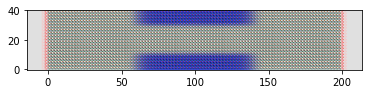

/usr/local/anaconda3/envs/kwant/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: The plotted data contains 1.50% of values overflowing upper limit 0.539055 


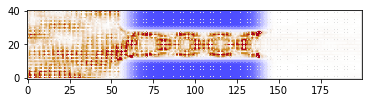

/usr/local/anaconda3/envs/kwant/lib/python3.6/site-packages/ipykernel_launcher.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


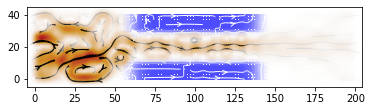

In [3]:
L=100
W=20

def V(site, V_0=100, L=L, W=W, ratio=0.25):
    L2=L*2
    W2=W*2
    sigx = L2/5 
    sigy = W2 * ratio
    
    (x, y) = site.pos
    return (V_0 * np.exp(-(((x - L2/2))/sigx ) **10 ))*(1 -np.exp(-(((y - W2/2)/sigy )) ** 10))

cmap = np.zeros([256, 4])
cmap[:, 2] = np.ones(256)
cmap[:, 3] = np.linspace(0, 0.7, 256)
cmap = matplotlib.colors.ListedColormap(cmap)

fsyst, syst, lead, lat = make_system(t_2=0, t_1=1, L=L, W=W, lead=True, potential=V)
fig, ax = plt.subplots()
kwant.plotter.map(syst, V, ax=ax, cmap=cmap, show=False)
kwant.plot(fsyst, ax=ax)
plt.show()

fig, ax = plt.subplots()
plot_density(fsyst,1, it=-1,title="empty", ax=ax)
kwant.plotter.map(syst, V, ax=ax, cmap=cmap)
plt.show()

fig, ax = plt.subplots()
plot_current(fsyst,1, it=-1,title="empty", ax=ax)
kwant.plotter.map(syst, V, ax=ax, cmap=cmap)
plt.show()

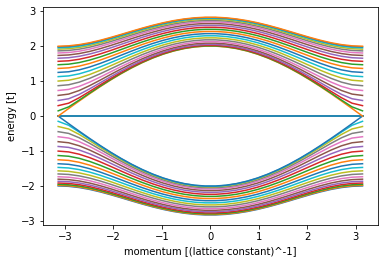

In [4]:
plot_bandstructure(lead, np.linspace(-np.pi, np.pi, 30))